# Práctica de Inteligencia Artificial: Predicción de Tipos de Cobertura Forestal

## Introducción

El objetivo de esta práctica es aplicar técnicas de aprendizaje automático para predecir el tipo de cobertura forestal utilizando el Forest Cover Type Dataset. Este conjunto de datos contiene información detallada sobre las características del suelo y la vegetación del Bosque Nacional de Roosevelt en Estados Unidos.

## 1. Preparación del Entorno y Carga de Datos

In [11]:
# Importación de librerías necesarias
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuración de estado aleatorio para reproducibilidad
RANDOM_STATE = 42

# Carga del conjunto de datos
df = pd.read_csv("covtype.csv")

## 2. Análisis Exploratorio de Datos (EDA)
### 2.1 Características Generales del Conjunto de Datos y Comprobación de Valores Nulos y Negativos

In [12]:
print(f"El conjunto de datos tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

print("\nA continuación se muestran las columnas que tienen valores nulos:")
if df.isnull().sum().sum() == 0:
    print("No hay valores nulos en el conjunto de datos.")
else:
    texto_columnas = ""
    for columna in df.columns:
        n_valores_nulos = df[columna].isnull().sum()
        if n_valores_nulos > 0:
            texto_columnas += f"{columna}: {n_valores_nulos} ({n_valores_nulos / df.shape[0] * 100:.2f}%)\n"
    print(texto_columnas)

print("\nA continuación se muestran las columnas que tienen valores negativos:")
if (df < 0).sum().sum() == 0:
    print("No hay valores negativos en el conjunto de datos.")
else:
    texto_columnas = ""
    for columna in df.columns:
        n_valores_negativos = df[df[columna] < 0].shape[0]
        if n_valores_negativos > 0:
            texto_columnas += f"{columna}: {n_valores_negativos} ({n_valores_negativos / df.shape[0] * 100:.2f}%)\n"
    print(texto_columnas)


El conjunto de datos tiene 581012 filas y 55 columnas.

A continuación se muestran las columnas que tienen valores nulos:
No hay valores nulos en el conjunto de datos.

A continuación se muestran las columnas que tienen valores negativos:
Vertical_Distance_To_Hydrology: 55143 (9.49%)



In [13]:
wilderness_area_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4"
]

soil_type_columns = [
    "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4", "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8",
    "Soil_Type9", "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14", "Soil_Type15",
    "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19", "Soil_Type20", "Soil_Type21", "Soil_Type22",
    "Soil_Type23", "Soil_Type24", "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34", "Soil_Type35", "Soil_Type36",
    "Soil_Type37", "Soil_Type38", "Soil_Type39", "Soil_Type40"
]

columnas_numericas = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points", "Hillshade_9am", "Hillshade_Noon",
    "Hillshade_3pm"
]

columnasConMasOMenosDeUnSoilType = df[soil_type_columns].sum(axis=1) != 1
muestras_con_multiples_soil_type = df[columnasConMasOMenosDeUnSoilType]
print("Número de muestras con múltiples tipos de suelo:", len(muestras_con_multiples_soil_type))

columnasConMasOMenosDeUnWildernessArea = df[wilderness_area_columns].sum(axis=1) != 1
muestras_con_multiples_wilderness_area = df[columnasConMasOMenosDeUnWildernessArea]
print("Número de muestras con múltiples áreas naturales:", len(muestras_con_multiples_wilderness_area))


Número de muestras con múltiples tipos de suelo: 0
Número de muestras con múltiples áreas naturales: 0


Como se puede ver, no hay ninguna fila que tenga varios Soil_Type o Wilderness_Area, por lo que son realmente variables categóricas en formato one hot encoding.

### 2.2 Distribución de Clases y Características

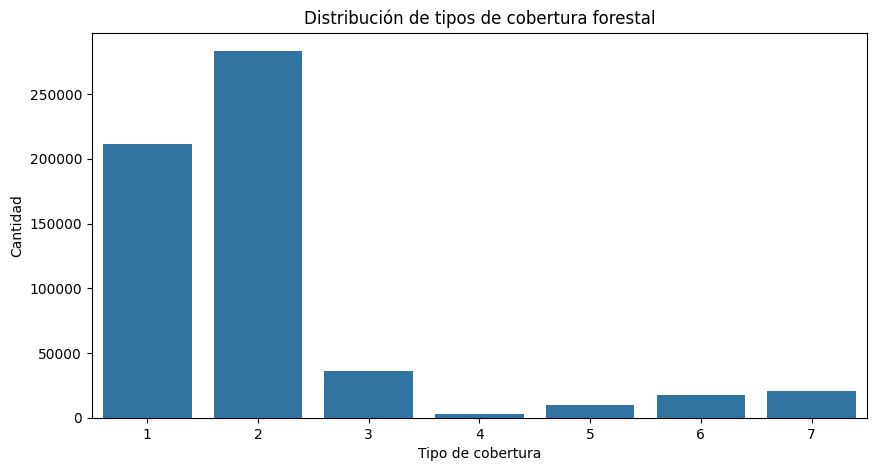

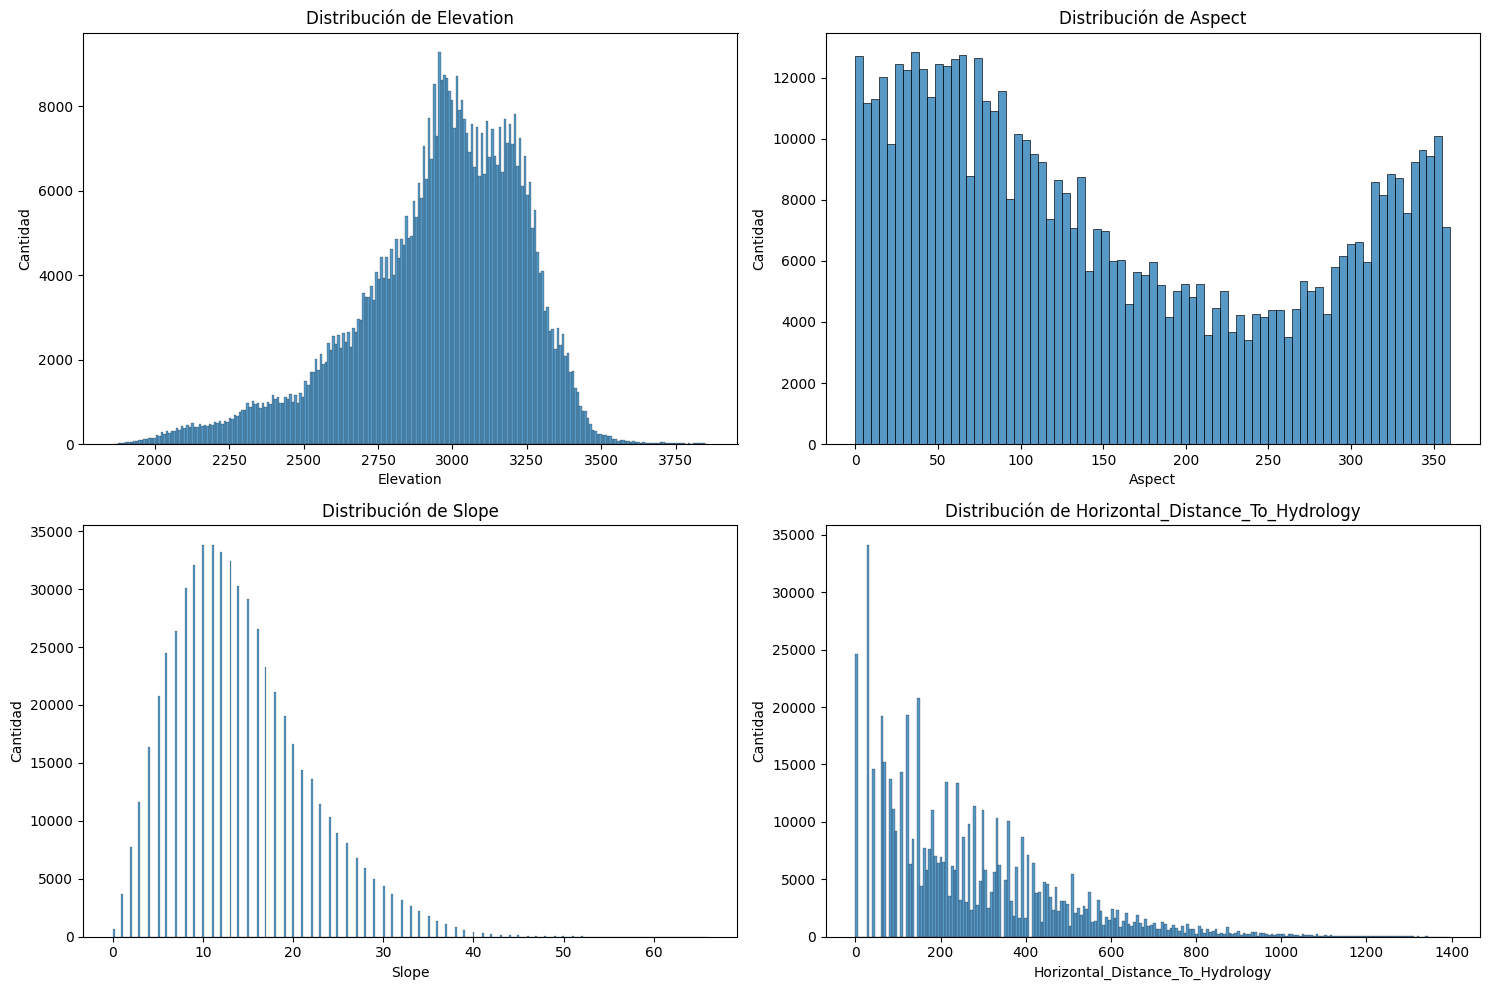

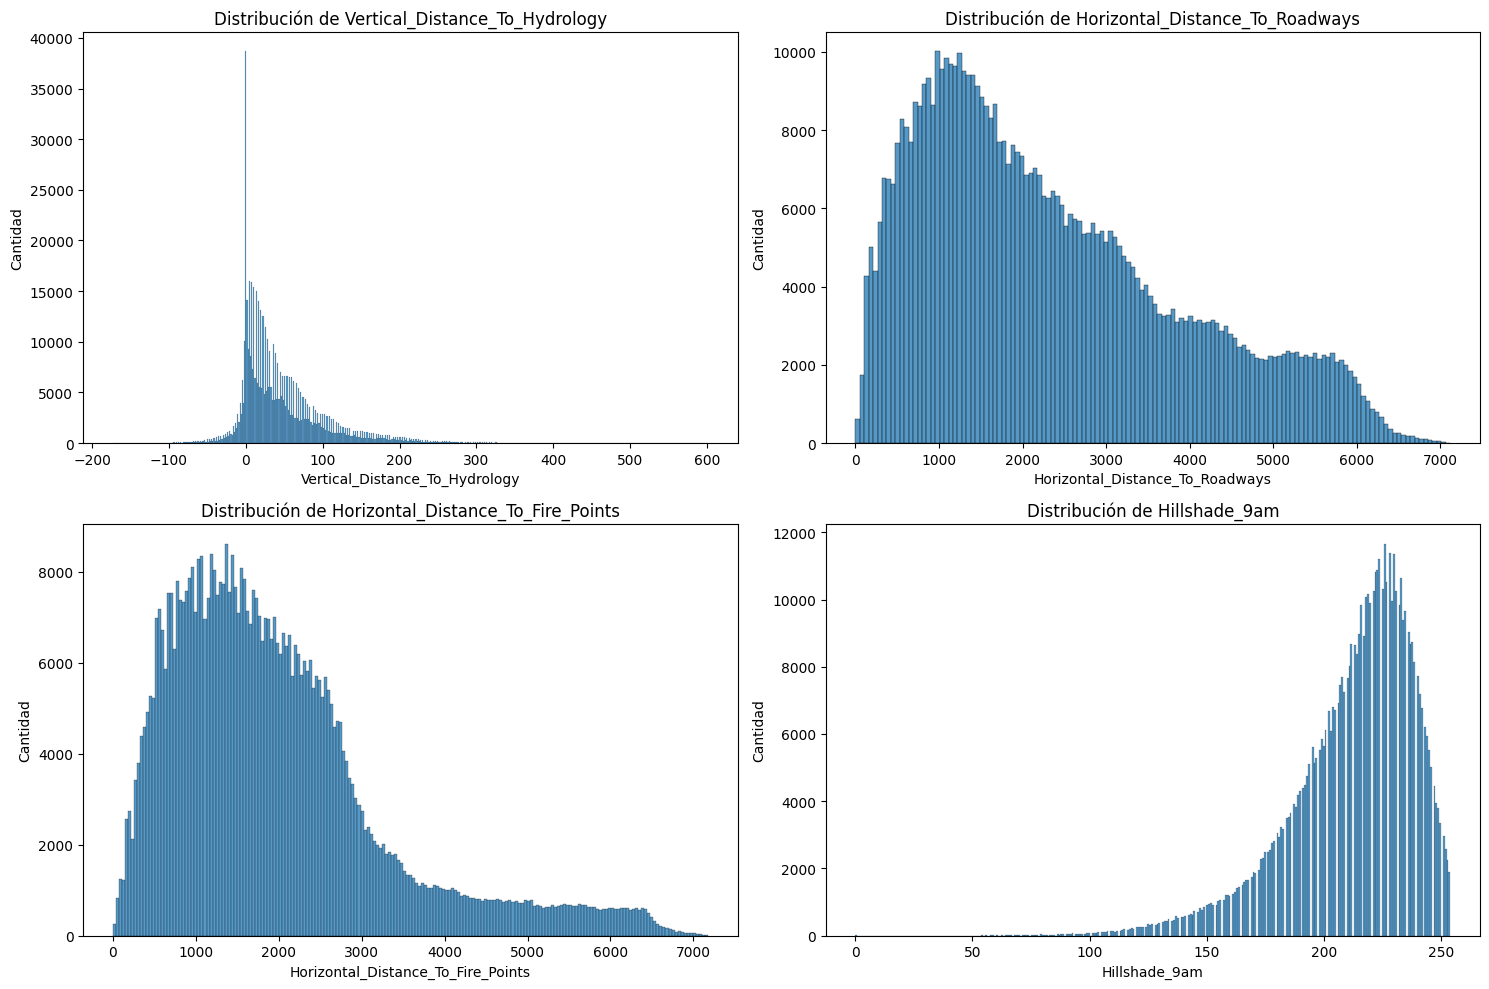

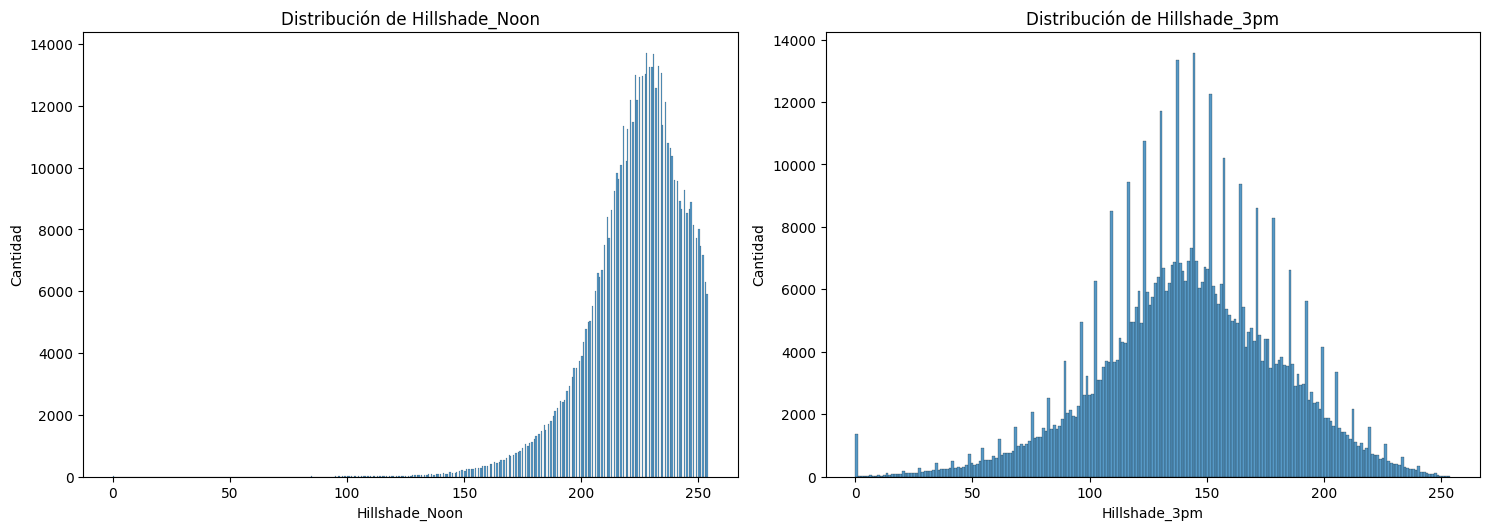

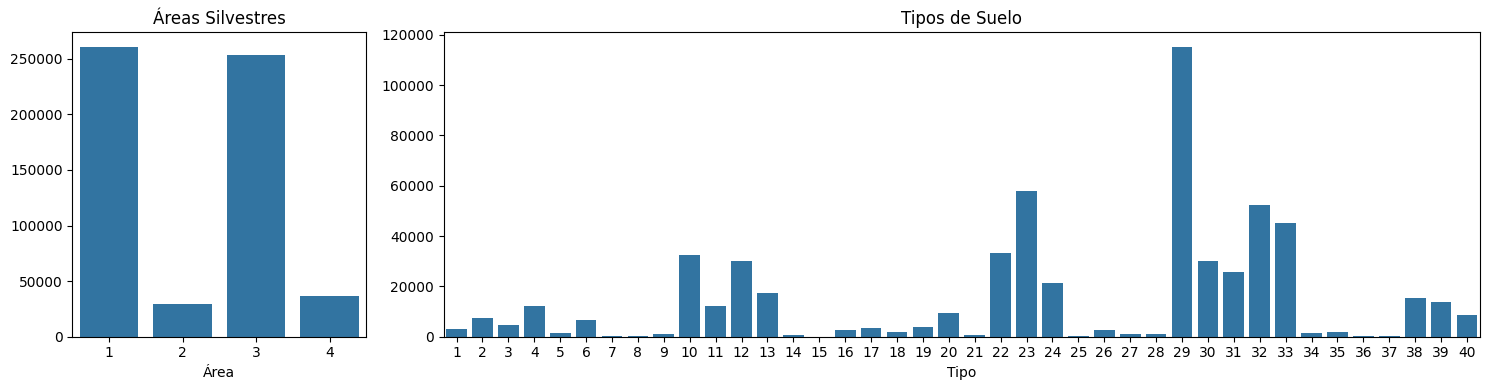

In [14]:
def mostrar_distribuciones(conjunto_datos):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=conjunto_datos, x="Cover_Type")
    plt.title("Distribución de tipos de cobertura forestal")
    plt.xlabel("Tipo de cobertura")
    plt.ylabel("Cantidad")
    plt.show()

    n_filas = 2
    n_cols = 2
    graficos_por_figura = n_filas * n_cols

    for i in range(0, len(columnas_numericas), graficos_por_figura):
        fig, axes = plt.subplots(n_filas, n_cols, figsize=(15, 10))
        axes = axes.flatten()

        for j in range(graficos_por_figura):
            if i + j < len(columnas_numericas):
                columna = columnas_numericas[i + j]
                sns.histplot(data=conjunto_datos, x=columna, ax=axes[j])
                axes[j].set_title("Distribución de " + columna)
                axes[j].set_xlabel(columna)
                axes[j].set_ylabel("Cantidad")
            else:
                axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 4, 1)
    conteo_areas_silvestres = conjunto_datos[wilderness_area_columns].sum()
    sns.barplot(x=[i.split("Wilderness_Area")[-1] for i in conteo_areas_silvestres.index],
                y=conteo_areas_silvestres.values)
    plt.title("Áreas Silvestres")
    plt.xlabel("Área")

    plt.subplot(1, 4, (2, 4))
    conteo_tipos_suelo = conjunto_datos[soil_type_columns].sum()
    sns.barplot(x=[i.split("Soil_Type")[-1] for i in conteo_tipos_suelo.index], y=conteo_tipos_suelo.values)
    plt.title("Tipos de Suelo")
    plt.xlabel("Tipo")

    plt.tight_layout()
    plt.show()


mostrar_distribuciones(df)


### 2.3 Balanceo de Clases con Undersampling

La clase más pequeña tiene 2747 muestras
El conjunto de datos balanceado tiene 19229 muestras


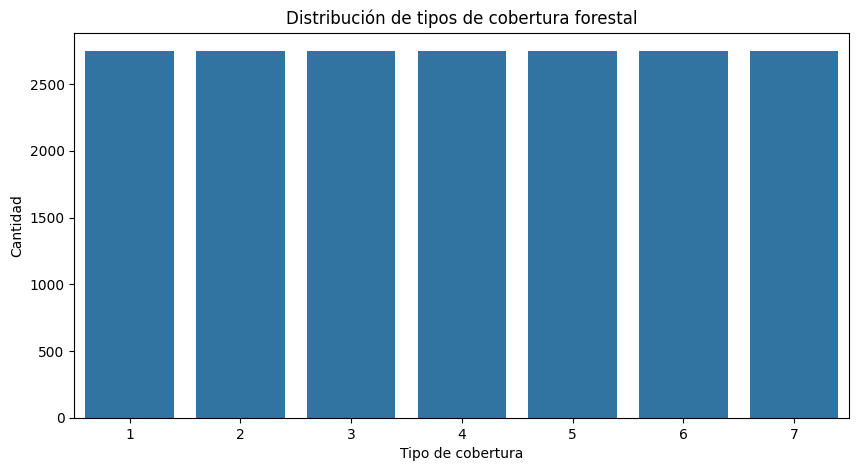

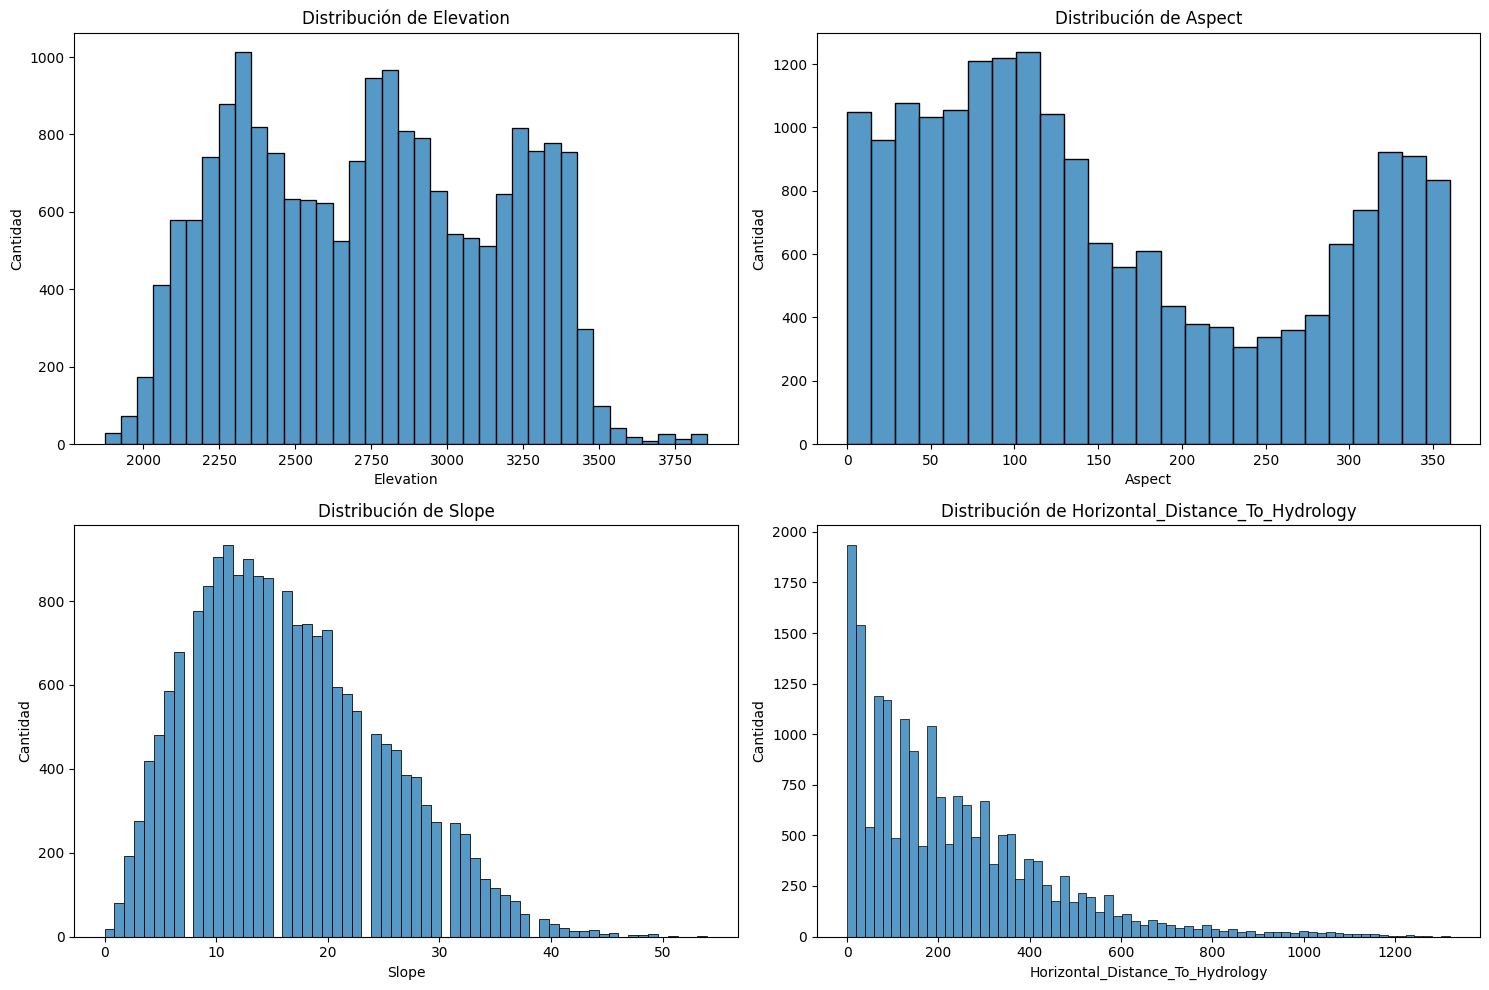

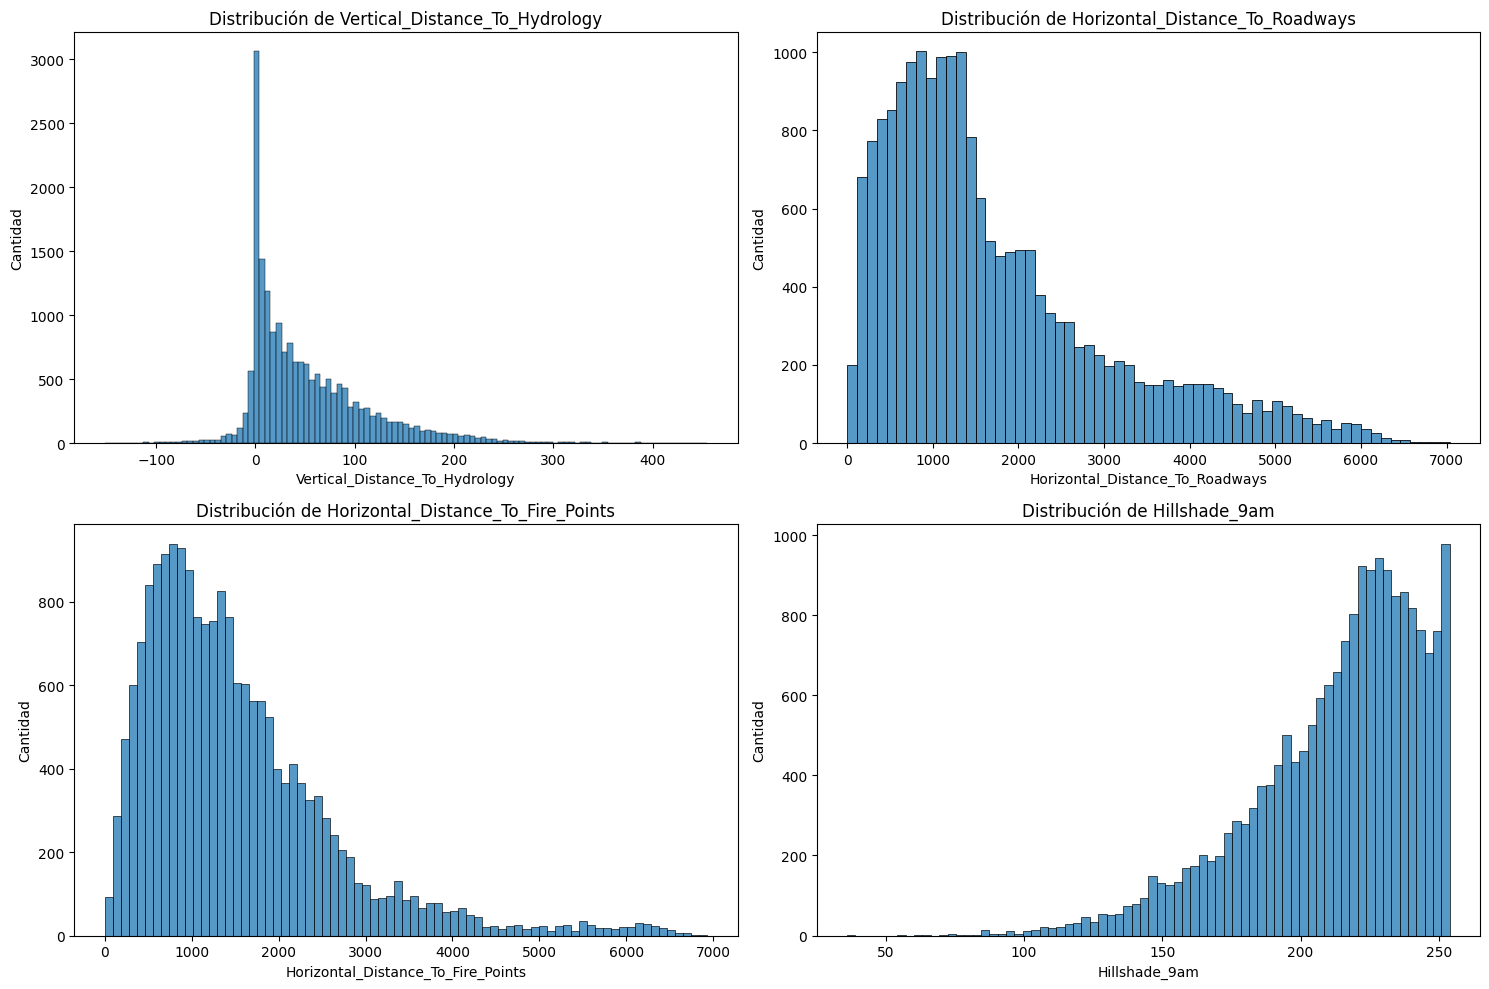

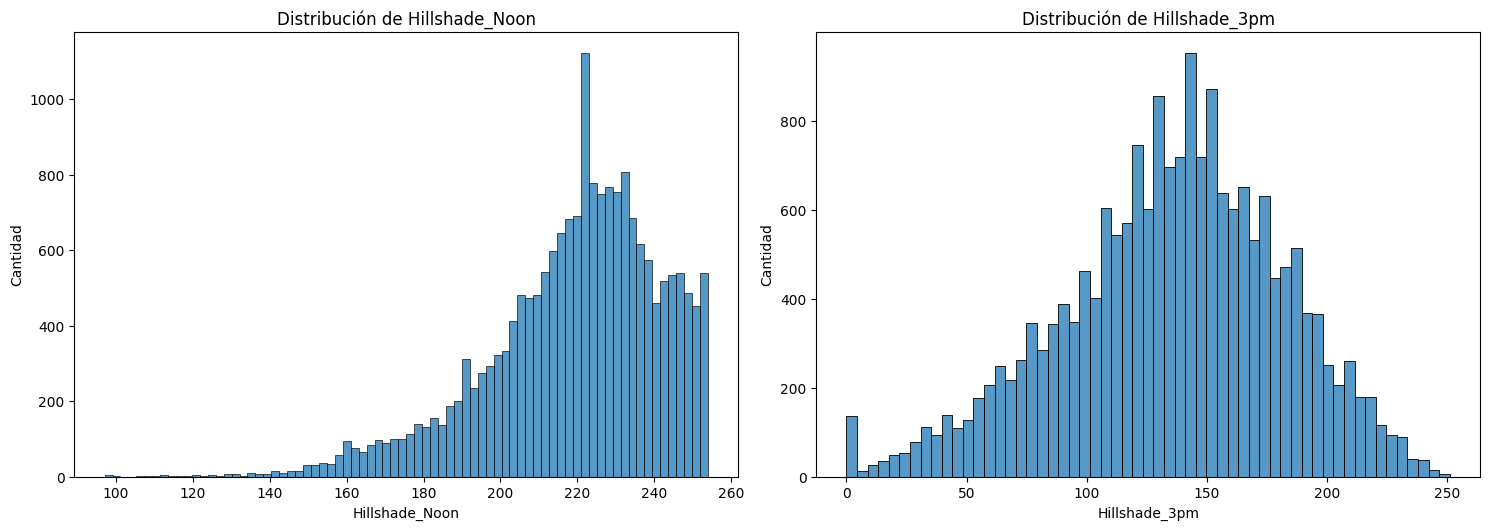

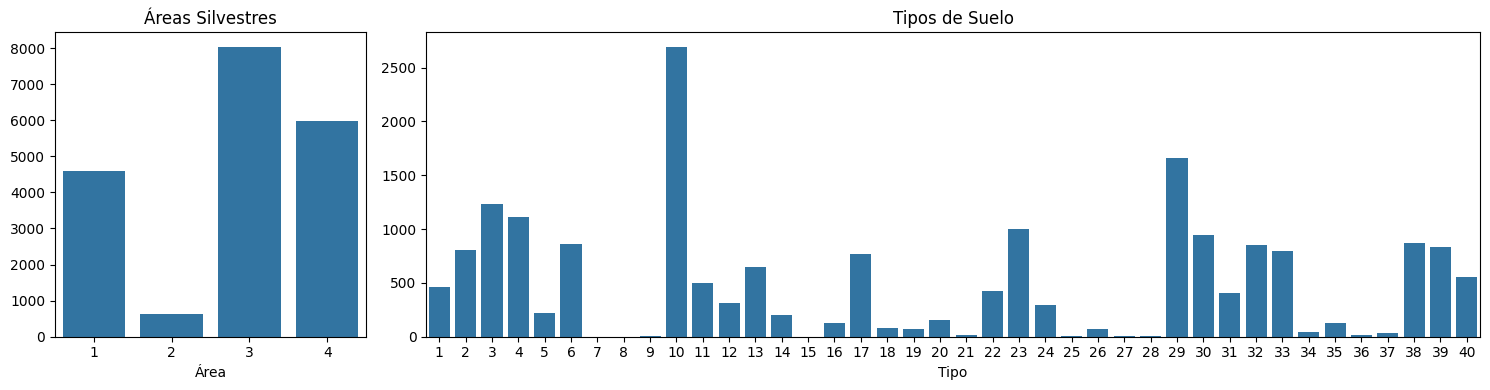

Todas las distribuciones menos Elevation, Wilderness Area y Soil Type siguen la misma distribución en el conjunto de datos balanceado.


In [15]:
def crear_subconjunto_balanceado(conjunto_datos, muestras_objetivo_por_clase):
    conteo_clases = conjunto_datos["Cover_Type"].value_counts()

    rus = RandomUnderSampler(sampling_strategy={
        i: min(count, muestras_objetivo_por_clase)
        for i, count in conteo_clases.items()
    }, random_state=RANDOM_STATE)

    X = conjunto_datos.drop("Cover_Type", axis=1)
    y = conjunto_datos["Cover_Type"]
    X_remuestreado, y_remuestreado = rus.fit_resample(X, y)

    return pd.concat([X_remuestreado, y_remuestreado], axis=1)


conteo_clase_min = df["Cover_Type"].value_counts().min()
print(f"La clase más pequeña tiene {conteo_clase_min} muestras")

df_balanceado = crear_subconjunto_balanceado(df, conteo_clase_min)
print(f"El conjunto de datos balanceado tiene {df_balanceado.shape[0]} muestras")
mostrar_distribuciones(df_balanceado)

print("Todas las distribuciones menos Elevation, Wilderness Area y Soil Type siguen la misma distribución en el conjunto de datos balanceado.")


### 2.4 Matriz de correlaciones

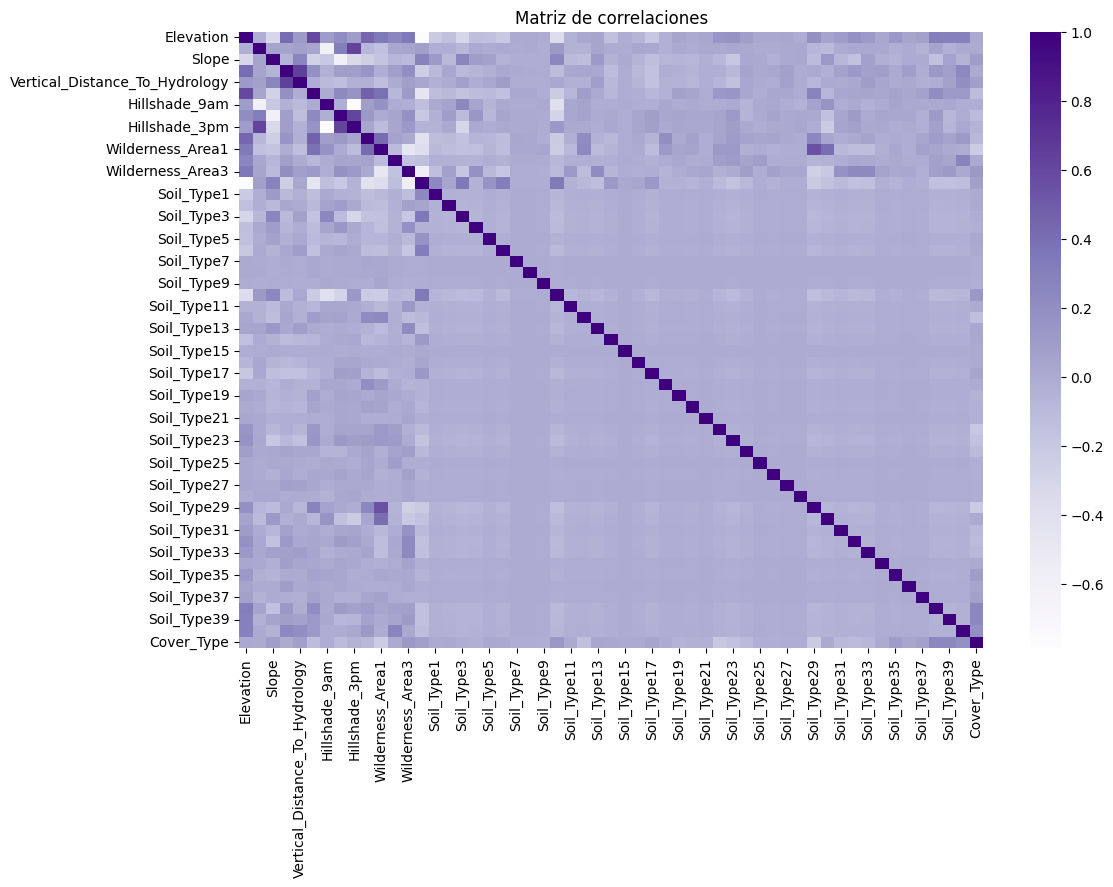

In [16]:
plt.figure(figsize=(12, 8))
matriz_corr = df_balanceado.corr()
sns.heatmap(matriz_corr, cmap="Purples", annot=False)
plt.title("Matriz de correlaciones")
plt.show()

### 2.5 Reducción de Dimensionalidad con PCA

In [17]:
y = df_balanceado["Cover_Type"]
X = df_balanceado.drop("Cover_Type", axis=1)

caracteristicas_numericas = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
                             "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
                             "Horizontal_Distance_To_Fire_Points", "Hillshade_9am",
                             "Hillshade_Noon", "Hillshade_3pm"]

caracteristicas_categoricas = [col for col in X.columns if col not in caracteristicas_numericas]

scaler = StandardScaler()
X[caracteristicas_numericas] = scaler.fit_transform(X[caracteristicas_numericas])

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X = pca.fit_transform(X)

print(f"PCA ha seleccionado {pca.n_components_} componentes principales.")

PCA ha seleccionado 10 componentes principales.


Como se puede ver, se ha pasado de tener 55 variables y 581012 muestras a 10 variables y 19229 muestras.

## 4. Entrenamiento y Evaluación de Modelos

In [18]:
modelos = {
    "Perceptron": {
        "model": Perceptron(),
        "params": {
            "max_iter": [1000],
            "alpha": [0.0001, 0.001, 0.01],
            "eta0": [10.0, 1.0, 0.1]
        }
    },
    "Regresión logística": {
        "model": LogisticRegression(),
        "params": {
            "max_iter": [1000],
            "C": [0.1, 1, 10]
        }
    },
    "Máquina de vector de soporte (SVM) lineal": {
        "model": SVC(),
        "params": {
            "kernel": ["linear"],
            "C": [0.1, 1, 10]
        }
    },
    "Máquina de vector de soporte (SVM) gaussiano": {
        "model": SVC(),
        "params": {
            "kernel": ["rbf"],
            "C": [0.1, 1, 10],
            "gamma": ["scale", "auto", 0.1, 1, 10]
        }
    },
    "Máquina de vector de soporte (SVM) polinómico": {
        "model": SVC(),
        "params": {
            "kernel": ["poly"],
            "C": [1], # reducir el número de combinaciones para ahorrar tiempo
            "gamma": ["scale", "auto", 1], # reducir el número de combinaciones para ahorrar tiempo
            "degree": [2, 3] # no considerar 4 para ahorrar tiempo
        }
    },
    "Árbol de decisión": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "criterion": ["gini", "entropy"]
        }
    },
    "Bosque aleatorio": {
        "model": RandomForestClassifier(),
        "params": {
            "max_depth": [None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "criterion": ["gini", "entropy"],
            "n_estimators": [50, 100, 200]
        }
    }
}

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

resultados_modelos = {}
for nombre, info_modelo in modelos.items():
    print(f"\nEntrenando {nombre}...")
    grid = GridSearchCV(info_modelo["model"],
                        info_modelo["params"],
                        cv=cv,
                        scoring="accuracy",  # se usa accuracy y no F1 para priorizar velocidad
                        n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    resultados_modelos[nombre] = {
        "best_estimator": grid.best_estimator_
    }

    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Precisión en validación: {grid.best_score_:.3f}")
    print(f"Precisión en test: {accuracy_score(y_test, y_pred):.3f}")


Entrenando Perceptron...
Mejores parámetros: {'alpha': 0.0001, 'eta0': 0.1, 'max_iter': 1000}
Precisión en validación: 0.462
Precisión en test: 0.495

Entrenando Regresión logística...
Mejores parámetros: {'C': 10, 'max_iter': 1000}
Precisión en validación: 0.668
Precisión en test: 0.667

Entrenando Máquina de vector de soporte (SVM) lineal...
Mejores parámetros: {'C': 10, 'kernel': 'linear'}
Precisión en validación: 0.680
Precisión en test: 0.679

Entrenando Máquina de vector de soporte (SVM) gaussiano...
Mejores parámetros: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Precisión en validación: 0.812
Precisión en test: 0.825

Entrenando Árbol de decisión...
Mejores parámetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Precisión en validación: 0.659
Precisión en test: 0.689

Entrenando Bosque aleatorio...
Mejores parámetros: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Precisión e

## 5. Resultados y Discusión

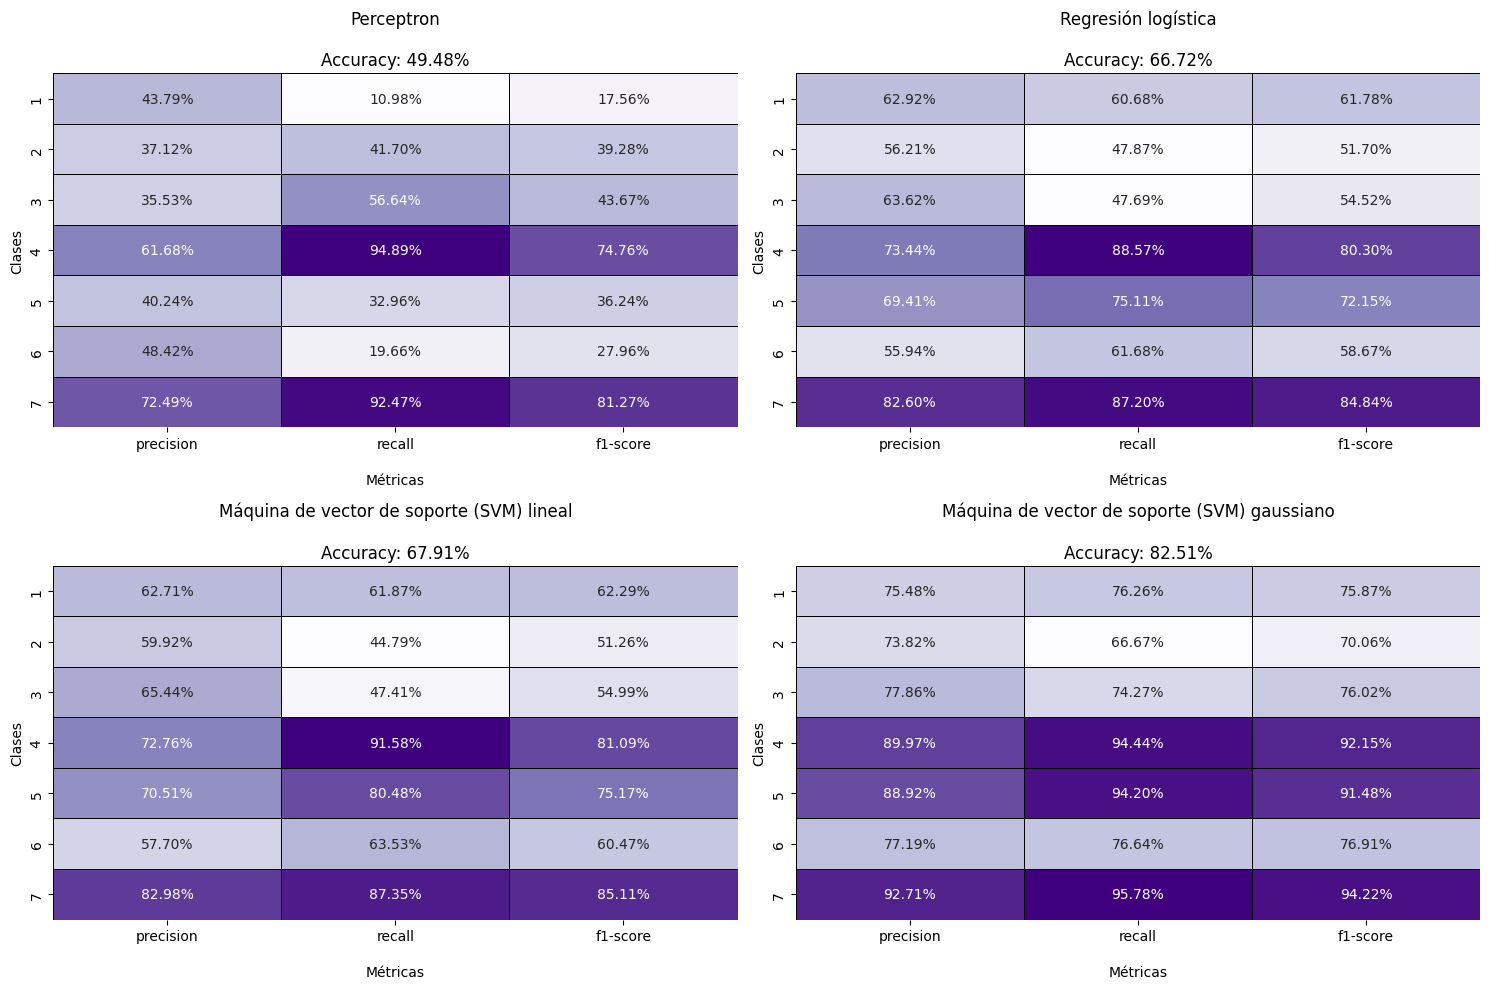

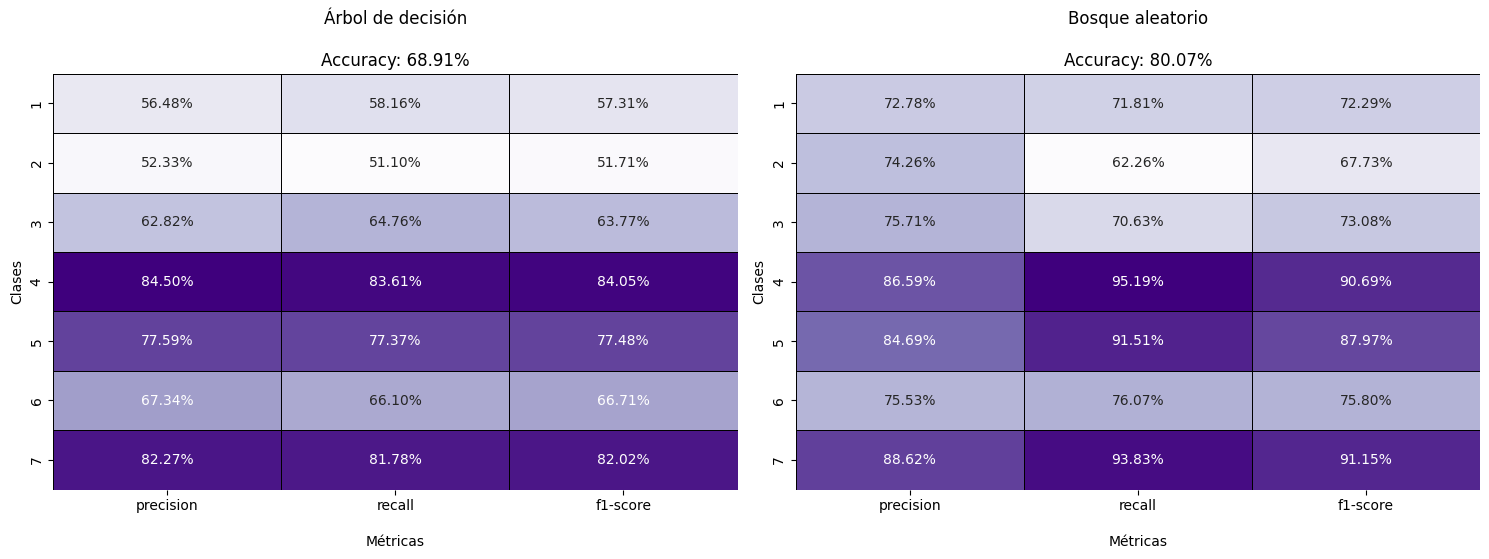

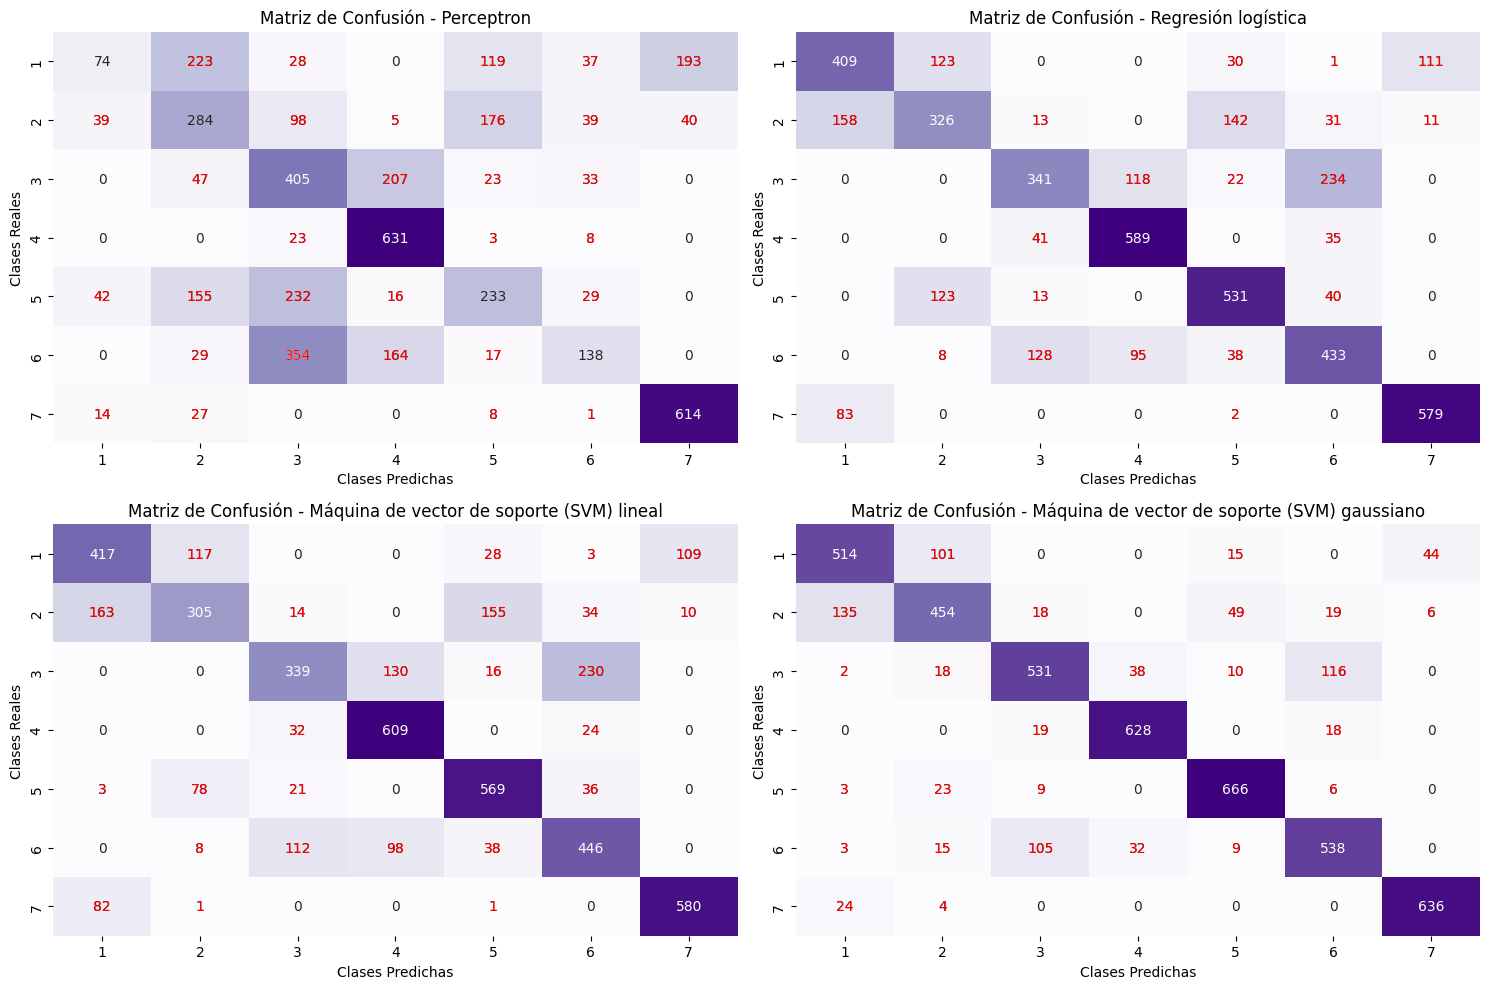

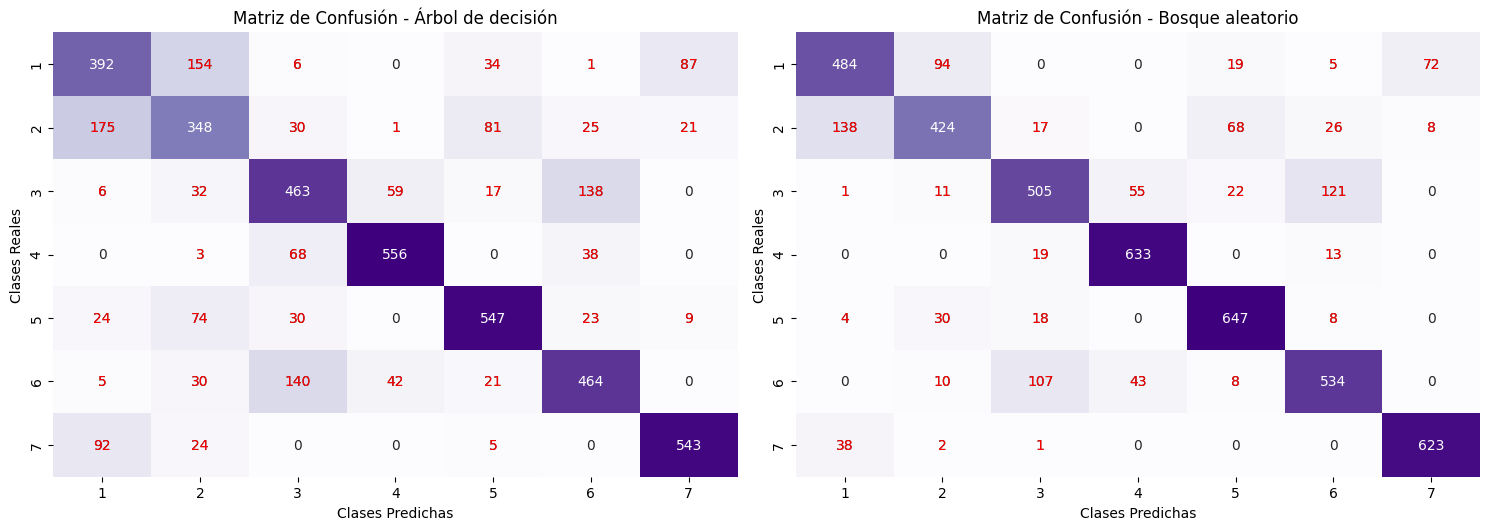

In [20]:
def plot_performance(n_rows=2, n_cols=2):
    plots_por_figura = n_rows * n_cols

    for i in range(0, len(resultados_modelos), plots_por_figura):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
        axes = axes.flatten()

        for j in range(plots_por_figura):
            if i + j < len(resultados_modelos):
                model_name = list(resultados_modelos.keys())[i + j]
                model = resultados_modelos[model_name]["best_estimator"]
                y_pred = model.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                class_report = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)

                df_class_report = pd.DataFrame(class_report).transpose()

                sn.heatmap(df_class_report.iloc[:-3, :-1], annot=True, fmt=".2%", cmap="Purples", cbar=False,
                           linewidths=0.5, linecolor="black", annot_kws={"size": 10}, ax=axes[j])

                axes[j].set_xlabel("\nMétricas")
                axes[j].set_ylabel("Clases")
                axes[j].set_title(f"{model_name}\n\nAccuracy: {accuracy:.2%}")
            else:
                axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    for i in range(0, len(resultados_modelos), plots_por_figura):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
        axes = axes.flatten()

        for j in range(plots_por_figura):
            if i + j < len(resultados_modelos):
                model_name = list(resultados_modelos.keys())[i + j]
                model = resultados_modelos[model_name]["best_estimator"]
                y_pred = model.predict(X_test)
                conf_mat = confusion_matrix(y_test, y_pred)

                sn.heatmap(conf_mat, annot=True, fmt="d", cmap="Purples", cbar=False, xticklabels=model.classes_,
                           yticklabels=model.classes_, ax=axes[j])

                axes[j].set_xlabel("Clases Predichas")
                axes[j].set_ylabel("Clases Reales")
                axes[j].set_title(f"Matriz de Confusión - {model_name}")

                for k in range(conf_mat.shape[0]):
                    for l in range(conf_mat.shape[1]):
                        if k != l and conf_mat[k, l] != 0:
                            axes[j].text(l + 0.5, k + 0.5, str(conf_mat[k, l]), color="red", ha="center", va="center")
            else:
                axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()


plot_performance()

## 6. Conclusiones
